In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
# May take a couple minutes!
import torch
import torchvision
from torchvision.transforms import v2

# Dataset Loading and Transforms
### - Data is loaded with torchvision ImageFolder (each image is 45x45 pixels)
### - Then transformed via torchvision v2 transformations:
      * Grayscale
      * Normalize
      * ToTensor (deprecated, so using ToImage() and ToDtype())

### - Finally, the resulting data set is split into three: Training, Validation, and Testing

## See GeeksForGeeks for example:
### - https://www.geeksforgeeks.org/machine-learning/implementation-of-a-cnn-based-image-classifier-using-pytorch/

In [3]:
DATA_PATH = "./data/"
BATCH_SIZE = 64

transformations = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Grayscale(),
    v2.Normalize((0.5,), (0.5,)) #Transform values [0, 1] -> [-1, 1] 
])

dataset = torchvision.datasets.ImageFolder(
    root=DATA_PATH,
    transform=transformations,
)

#Split dataset into train and test sets 80%-10%-10% train-validate-test split.
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

#Load -> see https://docs.pytorch.org/docs/stable/data.html for performance tuning (i.e, num_workers > 0 and pin_memory=True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

### Let's See Some Samples!

There are 82 classes!


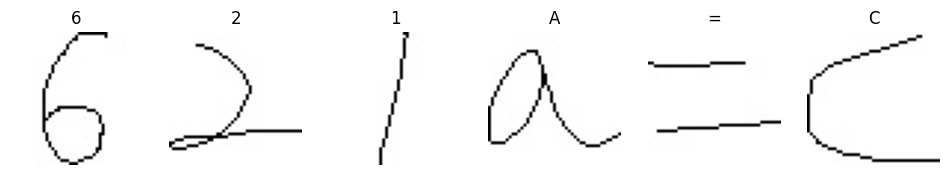

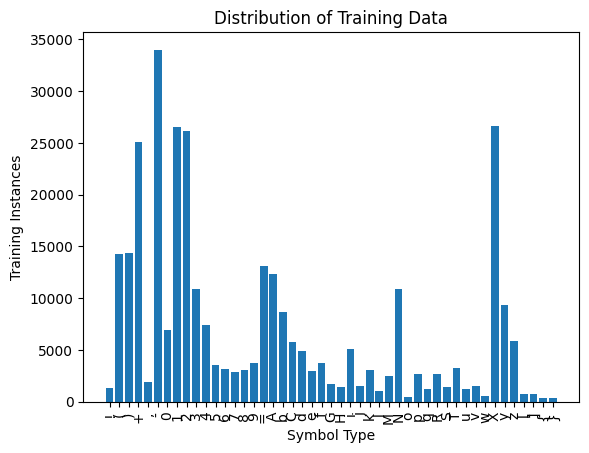

In [4]:
#Print some of the downloaded data (directly from folders)

images, labels = next(iter(train_loader))
print(f"There are {len(os.listdir(DATA_PATH))} classes!")

fig, axes = plt.subplots(1, 6, figsize=(12, 3))
for i in range(6):
    img = images[i].squeeze().numpy()
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(dataset.classes[labels[i]])
    axes[i].axis('off')

plt.show()


classes = [sym for sym in os.listdir(DATA_PATH) if len(sym) == 1];
counts = [len(os.listdir(DATA_PATH + symbol)) for symbol in classes if len(symbol) == 1];
plt.bar(classes, counts);
plt.xlabel("Symbol Type");
plt.ylabel("Training Instances");
plt.title("Distribution of Training Data");
plt.xticks(rotation=90);




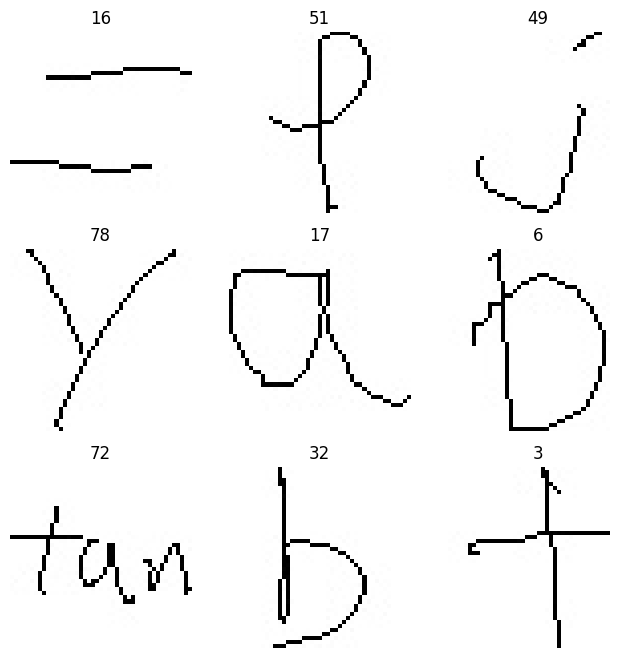

In [5]:
#Print some of the loaded data, with their corresponding classes

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx] #Images have shape [1, 45, 45] -> [channels, height, width]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating the Neural Network

### 1.  Input
- Images are tensors of shape ```[1, 45, 45]```
- Batch Sizes are 64 (```BATCH_SIZE``` constant)

### 2.  Convolutional Layers
1.  1 input channel, 32 output channels, 3x3 kernel, 1px padding
    - ```[1, 45, 45]``` -> ```[32, 45, 45]```
2.  32 input channels, 64 output channels, 3x3 kernel, 1px padding
    - ```[32, 45, 45]``` -> ```[64, 45, 45]```

### 3. ReLU Layers
- ```torch.nn.ReLU``` Applied after each convolution to introduce non-linearity.

### 4.  Pooling Layers
- 2d Max Pool -> halve dimensions to save computation power. (2x2 kernel; stride of 2)
  * ```[64, 45, 45]``` -> ```[64, 22, 22]```
  
### 5. Dense Layers
1. Flatten the feature map with ```torch.nn.flatten```
2. First dense layer (```torch.nn.Linear```) -> 128 output channels
3. Second dense layer -> output channels correspond to each symbol class

### 6. Additional (Dropout)
- After initial training over 35 epochs, training loss drops extremely quickly. To prevent overfitting, I'll introduce two dropout layers (one after the convolutional layers, and one after the dense layers). I'll also reduce the number of epochs to ten, and measure validation loss.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        # Non-Linear Layers
        self.relu = nn.ReLU()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=32,
            kernel_size=3, 
            padding=1,
        )
        self.conv2 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            padding=1,
        )

        # Dropout Layers
        self.drop1 = nn.Dropout(p=0.5)
        self.drop2 = nn.Dropout(p=0.25)
        
        # Max Pooling Layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten Layers
        self.flatten = nn.Flatten()
        
        # Dense Layers
        self.dense1 = nn.Linear(
            in_features=64 * 22 * 22, 
            out_features=128,
        )
        self.dense2 = nn.Linear(
            in_features=128, 
            out_features=num_classes,
        )


    def forward(self, x):
        # Convolutional Layers
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.drop1(x)
        
        # Pooling
        x = self.pool(x)

        # Flatten and Dense Layers
        x = self.flatten(x)
        x = self.relu(self.dense1(x))
        x = self.drop2(x)
        x = self.dense2(x)

        
        return x


# Training the Neural Network

### 1. Loss Function
- Using ```torch.nn.CrossEntropyLoss```

### 2. Optimization
- Using PyTorch builtin ```torch.optim.Adam``` optimizer

### 3. Training Loop:
    1. The model will be trained over 15 epochs.
    2. At each epoch, the model will do a forward pass of the images in the training dataset, and update the weights
    3. Then, the model will test against the validation set. When validation loss plateaus, the training will stop early.
        * Each epoch takes 15-30 minutes with the current optimizations; validation loss plateaus at ~epoch 11
### See PyTorch for example:
* https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html
* https://www.geeksforgeeks.org/machine-learning/training-neural-networks-with-validation-using-pytorch/

In [7]:
from time import time

CHECKPOINT_PATH = ".pth"
MODEL_PATH = "model.pth"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MIN_VALID_LOSS = 0.005 #Minimum necessary progress to keep training, otherwise ends training to avoid overfitting.

def trainNN(model, optimizer, loss_function, train_loader, val_loader):
    # Initialize
    history = {
        'train_loss': [],
        'train_acc': [],
        
        'val_acc': [],
        'val_loss': [],
        
        'epoch_time': [],
    }

    # Load relevant objects onto GPU (see performance tuning guide)
    model.to(DEVICE)
    print(f"Training with {DEVICE}")
    
    train_start = time()
    for epoch in range(NUM_EPOCHS):
        epoch_start = time()

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # ============== TRAINING ==============
        for images, labels in train_loader:
            # load to device
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            # optimizer.zero_grad() -> replace with iteration (see performance tuning guide)
            for param in model.parameters():
                param.grad = None
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1) #Get output with highest score
            correct += (predicted == labels).sum().item() #Count number of correct guesses
            total += labels.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total

        # ============== VALIDATION ==============
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad(): #Disable gradient calculation (see performance tuning guide)
            for images, labels in val_loader:
                # load to device
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                
                outputs = model(images)
                loss = loss_function(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_correct / val_total


        # ============== DATA CHECKPOINT ==============
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["epoch_time"].append(time() - epoch_start)

        checkpoint = {
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history,
        }
        torch.save(checkpoint, f"epoch{epoch+1}_" + CHECKPOINT_PATH)
        
        print(f"\t- Epoch {epoch + 1}: {history['epoch_time'][epoch] / 60:.2f} minutes")
        print(f"\t\t* Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} ")
        print(f"\t\t* Validation Loss: {val_loss:.4f}, Validation Acc: {100 * val_acc:.4f} ")

        if history['val_loss'][epoch - 1] - val_loss < MIN_VALID_LOSS :
            print(f"Validation testing did not improve a sufficient amount! stopping training early.")
            break
        
    print(f"Training complete in {(time() - train_start) / 60 / 60:.2f} hours")
    torch.save(model.state_dict(), MODEL_PATH)
    return model, history

In [8]:
NUM_EPOCHS = 15
NUM_CLASSES = len(dataset.classes)
PRE_TRAINED = True #I've already trained the model, so we'll avoid the expensive computation by loading the checkpoint.

model = NeuralNetwork(NUM_CLASSES).to(DEVICE)

if PRE_TRAINED:
    checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['model_state'])
    history = checkpoint['history']
else:
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    model, history = trainNN(model, optimizer, loss_function, train_loader, val_loader) 

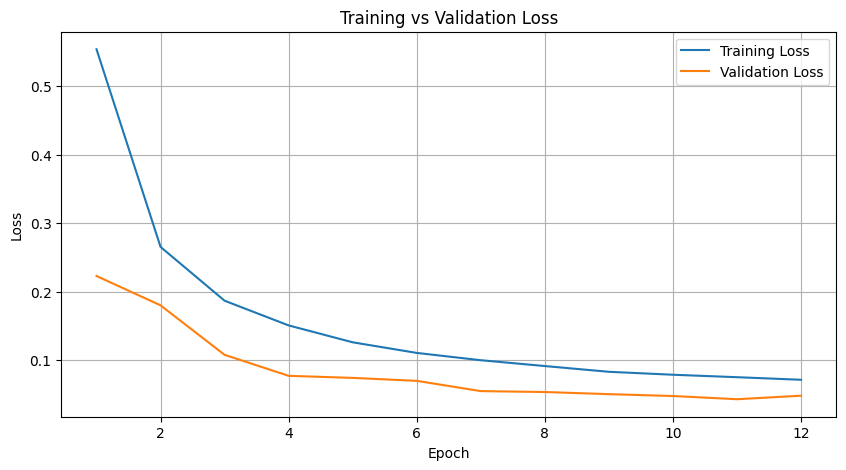

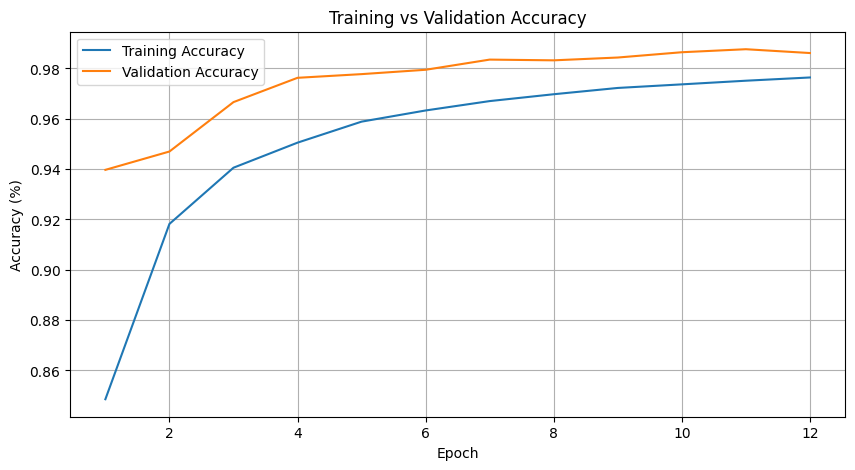

In [9]:
def plot_history(history):
    num_epochs = range(1, len(history['epoch_time']) + 1)

    # ============== Loss Plot ==============
    plt.figure(figsize=(10, 5))
    plt.plot(num_epochs, history['train_loss'], label='Training Loss')
    plt.plot(num_epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ============== Accuracy Plot ==============
    plt.figure(figsize=(10, 5))
    plt.plot(num_epochs, history['train_acc'], label='Training Accuracy')
    plt.plot(num_epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_history(history)

# Evaluating the Trained Model

In [10]:
import sklearn.metrics

In [11]:
# May take a few minutes!
TEST = False
if TEST:
    model.to(DEVICE)
    model.eval()
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    test_start = time()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
    
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f"Finished Testing in {(time() - test_start) / 60:.2f} minutes\n\t- Accuracy: {100 * correct / total:.2f}%")

In [12]:
# Visualize confusion matrices for a subset of classes
if TEST:
    fig, axes = plt.subplots(1, 3, figsize=(14, 6))
    
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=all_labels,
        y_pred=all_predictions,
        labels=range(6, 16),
        display_labels=range(10),
        colorbar=False,
        cmap="Reds",
        ax=axes[0],
    );
    axes[0].set_title("Confusion Matrix - Digits")
    
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=all_labels,
        y_pred=all_predictions,
        labels=(3, 5, 74, 41),
        display_labels=('+', '-', '*', '/'),
        colorbar=False,    
        cmap="Reds",
        ax=axes[1],
    );
    axes[1].set_title("Confusion Matrix - Operations")

    print(dataset.classes)
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y_true=all_labels,
        y_pred=all_predictions,
        labels=(11, 12, 49, 39),
        display_labels=('5', '6', 'j', 'f'),
        colorbar=False,
        cmap="Reds",
        ax=axes[2],
    );
    axes[2].set_title("Confusion Matrix - Commonly Confused")

## Next Up: User Input
- User input is drawn onto two canvases at once:
    1. A Tkinter Canvas widget for displaying in-notebook
    2. A Pillow ImageDraw canvas for saving to disk
#### CV2 References:
    - https://docs.opencv.org/4.x/d9/d8b/tutorial_py_contours_hierarchy.html (symbol isolation)
    - https://opencv.org/blog/resizing-and-rescaling-images-with-opencv/ (rescaling)
    
#### Canvas References:
    - https://python-course.eu/tkinter/canvas-widgets-in-tkinter.php
    - https://stackoverflow.com/questions/70403360/drawing-with-mouse-on-tkinter-canvas

In [44]:
import cv2
from skimage.morphology import skeletonize

class ImageProcessor:
    """Input processing pipeline:
        
            1. Fetch image
            2. Symbol isolation
            3. Image preprocessing
            4. CNN classification
            5. Equation parsing
    """
    def __init__(self, model):
        self.model = model.cpu()

    def process(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        #1. Isolate Symbols
        symbols = self.isolate_symbols(img)
        self.visualize_syms(symbols)

        #2. Preprocess Symbols
        symbol_tensor = self.preprocess_symbols(symbols)
        self.visualize_preprocessed(symbol_tensor)
        
        #3 Classification
        predictions = self.classify_symbols(symbol_tensor)
        classes = [dataset.classes[p.item()] for p in predictions]
        print(classes)

    def isolate_symbols(self, img):
        """Use contours to identify the bounding boxes of each symbol -> list of np.ndarrays"""

        # Binarize (black background, white symbols)
        _, binarized = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY_INV)

        # Extract contours
        contours, _ = cv2.findContours(binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        symbols = []
        x_coords = []

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            # Crop symbol
            symbol = binarized[y:y+h, x:x+w]
            symbols.append(symbol)
            x_coords.append(x)

        # Sort by x-coord of contour
        symbols = [sym for _, sym in sorted(zip(x_coords, symbols), key=lambda b: b[0])]        
        return symbols

    def visualize_syms(self, symbols):
        """Helper tool to visualize each symbol"""
        rows = (len(symbols) + cols - 1) // cols  # number of rows
        plt.figure(figsize=(cols, rows))
    
        for i, symbol in enumerate(symbols):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(symbol, cmap="gray")
            plt.axis("off")
    
        plt.tight_layout()
        plt.show()
        
    def preprocess_symbols(self, symbols):
        """Turn each 45x45 symbol into a tensor of shape [N, 1, 45, 45]"""
        processed = []

        for symbol in symbols:
            #1. Resize
            h, w = symbol.shape
            scale = min(45 / h, 45 / w)
            new_w, new_h = int(w * scale), int(h * scale)
            resized = cv2.resize(symbol, (new_w, new_h), interpolation=cv2.INTER_AREA)

            #2. Place onto a 45x45 white background
            bg = np.ones((45, 45), dtype=np.float32) * 0
            x_off = (45 - new_w) // 2
            y_off = (45 - new_h) // 2
            bg[y_off:y_off+new_h, x_off:x_off+new_w] = resized
            
            #3. Normalize to (-1, 1), invert
            _, bg = cv2.threshold(bg, 127, 255, cv2.THRESH_BINARY_INV)
            canvas = (bg.astype(np.float32) / 127.5) - 1.0

            #4. Convert to Tensor of shape [1, 1, 45, 45]
            sym_tensor = torch.from_numpy(bg).unsqueeze(0).float() / 255.0      # [0, 1]
            sym_tensor = (sym_tensor - 0.5) / 0.5                              # [-1, 1]
            
            processed.append(sym_tensor)

        return torch.stack(processed, dim=0)

    def visualize_preprocessed(self, sym_tensor, cols=8):
        """Helper tool to visualize the preprocessed images"""
        print(f"Symbols Batch has shape {sym_tensor.shape}")
        imgs = sym_tensor.clone().cpu()

        # Undo normalization: [-1,1] -> [0,1] for display
        imgs = (imgs * 0.5) + 0.5  
    
        N = imgs.shape[0]
        rows = (N + cols - 1) // cols
    
        plt.figure(figsize=(cols * 1.5, rows * 1.5))
        for i in range(N):
            plt.subplot(rows, cols, i+1)
            plt.imshow(imgs[i,0].numpy(), cmap="gray")
            plt.axis("off")
    
        plt.tight_layout()
        plt.show()
    
    def classify_symbols(self, symbol_tensor):
        """Run each symbol through the CNN to classify"""
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(symbol_tensor)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(probabilities, dim=1)
        return predictions

        

In [45]:
from tkinter import Tk, Canvas, Button, LEFT, RIGHT, BOTH, YES
from PIL import Image, ImageDraw, ImageTk
import os

CANVAS_W, CANVAS_H = 1500, 500
BACKGROUND = (255, 255, 255)
PEN_COLOR = (0, 0, 0) 
PEN_WIDTH = 12  

class InputCanvas:
    def __init__(self, model, out_dir="user_images", save_path="input.png"):
        self.out_dir = out_dir
        self.save_path = save_path
        
        self.last_x = None
        self.last_y = None
        self.drawing_image = Image.new("RGB", (CANVAS_W, CANVAS_H), BACKGROUND)
        self.draw = ImageDraw.Draw(self.drawing_image)
        self.root = Tk()
        self.root.title("Input Math Expression")

        self.canvas = Canvas(self.root, width=CANVAS_W, height=CANVAS_H, bg="white")
        self.canvas.pack(expand=YES, fill=BOTH)

        self.canvas.bind("<Button-1>", self.set_start)
        self.canvas.bind("<B1-Motion>", self.draw_line)
        self.canvas.bind("<ButtonRelease-1>", self.end_line)

        self.btn_frame_left = Button(self.root, text="Clear", command=self.clear_canvas)
        self.btn_frame_left.pack(side=LEFT, padx=8, pady=8)

        self.btn_frame_save = Button(self.root, text="Submit", command=self.submit_input)
        self.btn_frame_save.pack(side=RIGHT, padx=8, pady=8)

        self.processor = ImageProcessor(model)

    def set_start(self, event):
        """Start a new line on click"""
        self.last_x, self.last_y = event.x, event.y
    
    def draw_line(self, event):
        """Draw line from previous coord; update coords"""
        x, y = event.x, event.y
        if self.last_x is not None and self.last_y is not None:
            # Draw on the tkinter canvas
            self.canvas.create_line(self.last_x, self.last_y, x, y,
                               width=PEN_WIDTH,
                               capstyle="round",
                               smooth=True,
                               splinesteps=36,
                               fill="black")
            
            # Draw on the PIL image
            self.draw.line([(self.last_x, self.last_y), (x, y)], fill=PEN_COLOR, width=5)
        self.last_x, self.last_y = x, y
    
    def end_line(self, event=None):
        """End line on button-up"""
        self.last_x, self.last_y = None, None
    
    def clear_canvas(self):
        """Clear both canvases"""
        self.canvas.delete("all")
        self.drawing_image = Image.new("RGB", (CANVAS_W, CANVAS_H), BACKGROUND)
        self.draw = ImageDraw.Draw(self.drawing_image)
    
    def submit_input(self):
        """Starts input processing pipeline"""
        self.save_img()
        self.processor.process(os.path.join(self.out_dir, self.save_path))
        
    def save_img(self):
        """Save canvas to disk"""
        os.makedirs(self.out_dir, exist_ok=True)
    
        # Save raw drawing
        raw_path = os.path.join(self.out_dir, self.save_path)
        self.drawing_image.save(raw_path)

    def start(self):
        self.root.mainloop()

### Let's test with some sample images

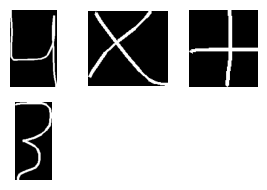

Symbols Batch has shape torch.Size([4, 1, 45, 45])


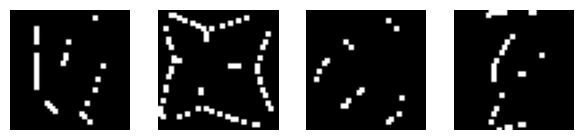

['tan', 'tan', 'tan', 'tan']


In [46]:
tester = ImageProcessor(model)

cv2.imshow("test1.png", cv2.imread("user_images/test1.png"))
cv2.waitKey(0)
cv2.destroyAllWindows()
tester.process("user_images/test1.png")

# cv2.imshow("test2.png", cv2.imread("user_images/test2.png"))
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# tester.process("user_images/test2.png")

### Let's test with user input

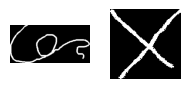

Symbols Batch has shape torch.Size([2, 1, 45, 45])


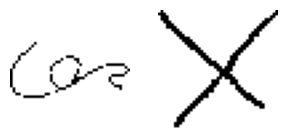

['cos', 'X']


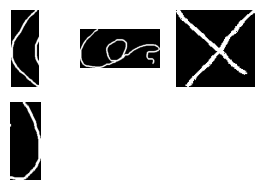

Symbols Batch has shape torch.Size([4, 1, 45, 45])


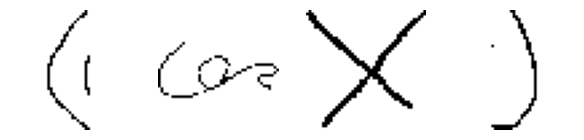

['k', 'cos', 'X', '0']


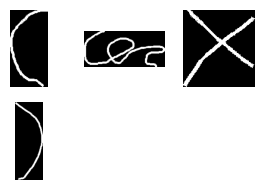

Symbols Batch has shape torch.Size([4, 1, 45, 45])


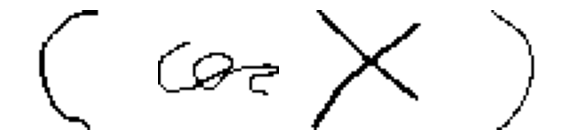

['R', 'cos', 'X', ')']


In [42]:
input_canvas = InputCanvas(model)
input_canvas.start()